In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
retailAll = 'data/retail-data/all/'
flightData2010 = 'data/flight-data/parquet/2010-summary.parquet'

### Resilient Distributed Datasets (RDDs)_

-  **Spak operates on a per-partition basis when executing code**
-  Basically all DF Spark code compiles down to an RDD
-  When calling a DF transformation, the underlying logic becomes a set of RDD transformations
-  SparkContext is the entry point for low-level API functionality accessed through SparkSession
-  Main reason to use RDDs is for fine grained control over physical distribution of data (**custom partitioning of data**)
-  _RDD performance is best via Scala/Java ... Python RDDs just require serializing the data to the Python process then perform the Python operation code then serialize it back to the JVM_
<br>
-  RDDs:
    -  **immutable, partitioned collection of records operated on in parallel as (Python, Scala, Java) objects**
    -  "Rows" do not exist in RDDs ... data records are just raw (Python, Scala, Java) objects   
    <br>
    -  Types:
        -  "generic" RDD
        -  key-value RDD
    -  Properties:
        -  list of partitions
        -  function for computing each split
        -  list of dependencies on other RDDs
        -  optional partitioner for key-value RDDs
        -  optional preferred locations on which to compute each split (ex: block locations for HDFS)
    -  Saving Files:
        -  RDDs can be written out to plain-text files
        -  RDDs can be written out to sequence files (flat file with binary key-value pairs) if in key-value format 
        -  Spark takes each partition and writes out to target destination
    -  Caching:
        -  ability to cache or persists an RDD
        -  ability to specify a storage level [org.apache.spark.storage.StorageLevel] (combinations of memory only, disk only, and off heap)
    -  Checkpointing:
        -  saves RDD to risk so future computations on that RDD point to its partitions on disk rather than recomputing the RDD from the original source
        -  similar to caching except checkpointing is stored only on disk and not in memory (like cache)
        -  when checkpointed RDD is referenced it derives from checkpoint instead of source data, which helps improve performance and optimization
    -  Finding Partitions:
        -  pipe helps with finding the # of lines per partition in RDD
        -  mapPartitions helps with finding the # of partitions in RDD
        -  mapPartitionsWithIndex helps with finding where each record in the RDD is mapped to what RDD partition
        -  foreachPartition helps with iterating over all the partitions of the data
        -  glom takes every partition in RDD and converts them to arrays **be CAREFUL because collecting large partitions can crash driver**   
        <br>
-  Shared Variables:
    -  broadcast variables
    -  accumulators

### _RDD to DF Example_

In [3]:
for i in spark.range(3).rdd.collect(): print(i)

Row(id=0)
Row(id=1)
Row(id=2)


In [4]:
spark.range(3).rdd.toDF().show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
+---+



### _Local Collection to RDD Example_

In [6]:
myCollection = "Training on Python, Spark, Scala, ML".split(" ")
words = spark.sparkContext.parallelize(myCollection, 2) # sets number of partitions

In [7]:
words.getNumPartitions()

2

In [8]:
words.setName("myWords") # names app for Spark UI
words.name()
for i in words.collect(): print(i)

Training
on
Python,
Spark,
Scala,
ML


### _RDD Data Source Read Example_

In [9]:
'''
spark.sparkContext.textFile(...) # reads text file line by line
spark.sparkContext.wholeTextFiles(...) # reads key-value (fileName, textFileValue)
'''

'\nspark.sparkContext.textFile(...) # reads text file line by line\nspark.sparkContext.wholeTextFiles(...) # reads key-value (fileName, textFileValue)\n'

### _RDD Transformation Examples_:
-  distinct [removes duplicates from RDD]
-  filter [where clause]
-  map [returns value based on input]
-  flatMap [returns mulitple values (splits) based on input]
-  sort [sort by variable]
-  randomSplit [randomly splits an RDD into an Array of RDDs]

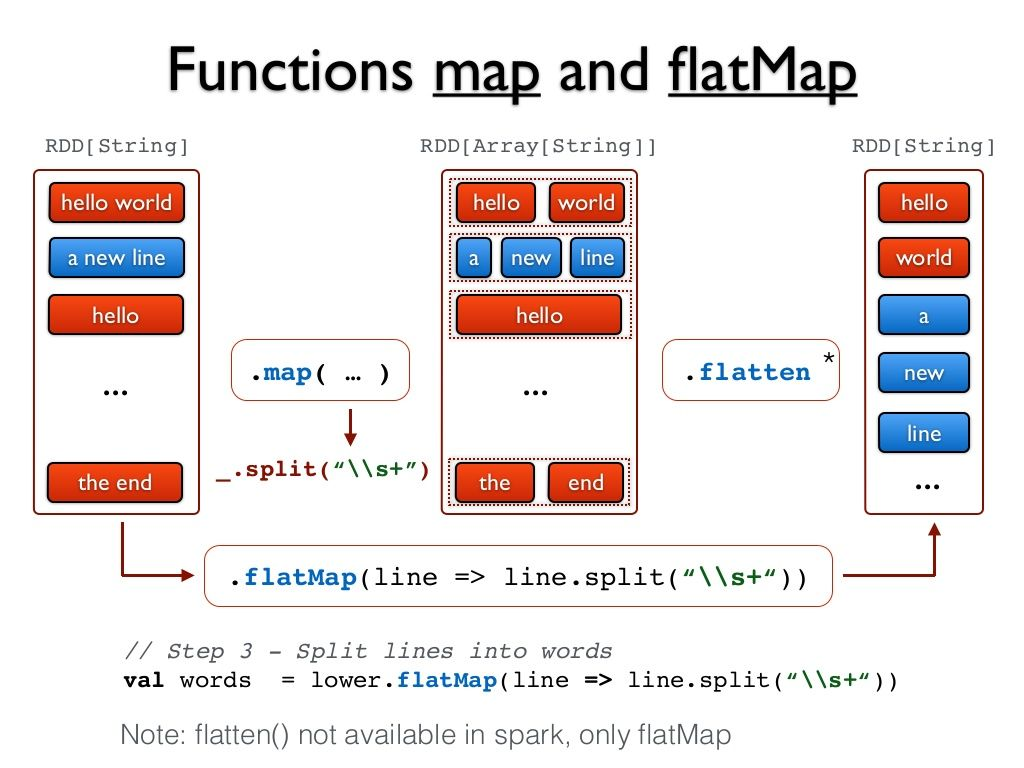

In [10]:
# distinct
print(words.distinct().count())

# filter
def startsWithS(individual):
  return individual.startswith("S")

print(words.filter(lambda word: startsWithS(word)).collect())

# map
words2 = words.map(lambda word: (word, word[0], word.startswith("S")))
print(words2.filter(lambda record: record[2]).collect())

# flatMap
print(words.flatMap(lambda word: list(word)).collect())

# sort
print(words.sortBy(lambda word: len(word) * -1).collect())

# randomSplit
fiftyFiftySplit = words.randomSplit([0.5, 0.5]) # [weight, random seed]

6
['Spark,', 'Scala,']
[('Spark,', 'S', True), ('Scala,', 'S', True)]
['T', 'r', 'a', 'i', 'n', 'i', 'n', 'g', 'o', 'n', 'P', 'y', 't', 'h', 'o', 'n', ',', 'S', 'p', 'a', 'r', 'k', ',', 'S', 'c', 'a', 'l', 'a', ',', 'M', 'L']
['Training', 'Python,', 'Spark,', 'Scala,', 'on', 'ML']


### RDD Actions Examples

In [11]:
# reduce
print(spark.sparkContext.parallelize(range(1, 21)).reduce(lambda x, y: x + y))


210


In [12]:
words.collect()

['Training', 'on', 'Python,', 'Spark,', 'Scala,', 'ML']

In [13]:
def wordLengthReducer(leftWord, rightWord):
  if len(leftWord) > len(rightWord):
    return leftWord
  else:
    return rightWord

print(words.reduce(wordLengthReducer))


Training


In [14]:
# count
print(words.count())

# countApprox
confidence = 0.95
timeoutMilliseconds = 400
print(words.countApprox(timeoutMilliseconds, confidence))



6
6


In [15]:
# countApproxDistinct
print(words.countApproxDistinct(0.05))

6


In [16]:
# countByValue
print(words.countByValue())


defaultdict(<class 'int'>, {'Training': 1, 'on': 1, 'Python,': 1, 'Spark,': 1, 'Scala,': 1, 'ML': 1})


In [17]:
# first
print(words.first())


Training


In [18]:
# take
print(words.take(3)) # returns values
print(words.takeOrdered(3)) # asc order

['Training', 'on', 'Python,']
['ML', 'Python,', 'Scala,']


In [19]:
withReplacement = True
numberToTake = 6
randomSeed = 100
print(words.takeSample(withReplacement, numberToTake, randomSeed)) # random sample from RDD

['Spark,', 'on', 'Python,', 'Spark,', 'Scala,', 'on']


### _RDD TXT Save (Uncompressed & Compressed) Example_

In [20]:
import shutil
#shutil.rmtree("/tmp/words")

words.saveAsTextFile("/tmp/words")

In [21]:
import os
for i in os.listdir("/tmp/words"): print(i)

part-00001
part-00000
_SUCCESS
.part-00001.crc
.part-00000.crc
._SUCCESS.crc


In [22]:
!head /tmp/words/part-00000
print("\n")
!head /tmp/words/part-00001

Training
on
Python,


Spark,
Scala,
ML


In [23]:
import shutil
#shutil.rmtree("/tmp/wordsCompressed")

words.saveAsTextFile("/tmp/wordsCompressed", \
                     compressionCodecClass="org.apache.hadoop.io.compress.GzipCodec")

In [24]:
import os
for i in os.listdir("/tmp/wordsCompressed/"): print(i)

part-00000.gz
_SUCCESS
.part-00001.gz.crc
.part-00000.gz.crc
part-00001.gz
._SUCCESS.crc


### _RDD Caching Example_

In [25]:
words.cache()

myWords ParallelCollectionRDD[20] at readRDDFromFile at PythonRDD.scala:247

### _RDD Checkpointing Example_

In [26]:
spark.sparkContext.setCheckpointDir("/tmp/checkpointRDD")
words.checkpoint()

### _RDD Partitions Examples_:
-  pipe
-  mapPartitions
-  mapPartitionsWithIndex

In [27]:
words.pipe("wc -l").collect() # five lines per partition

['3', '3']

In [28]:
words.mapPartitions(lambda part: [1]).sum() # value '1' for every partition in RDD then sum to get total # of partitions

2

In [29]:
def indexedFunc(partitionIndex, withinPartIterator):
  return ["partition: {} => {}".format(partitionIndex, x) for x in withinPartIterator]

words.mapPartitionsWithIndex(indexedFunc).collect()

['partition: 0 => Training',
 'partition: 0 => on',
 'partition: 0 => Python,',
 'partition: 1 => Spark,',
 'partition: 1 => Scala,',
 'partition: 1 => ML']

In [30]:
print(spark.sparkContext.parallelize(["Hello", "World"], 2).glom().collect())
print(type(spark.sparkContext.parallelize(["Hello", "World"], 2).glom().collect()))

[['Hello'], ['World']]
<class 'list'>


## Distributed Shared Variables_

-  Broadcast Variables:
    -  saves large value on all worker nodes without re-sending to cluster every time (ex: lookup table as function that fits in memory on each executor)
    -  avoids deserialization per task on the worker nodes every time variable is used
    -  shared immutable variables that are cached on every machine in cluster instead of serialized with every single task
    -  the cost of serializing data for every task can be quite expensive thus broadcast variables are a good alternative   
<br>
-  Accumulators:
    -  adds data together from all tasks into a shared result (ex: error logging counter and debugging)
    -  mutable variable that updates value via transformations and sends value to driver node in an efficient manner


In [40]:
my_collection = "Corporate Training for - Spark, Scala, Python".split(" ")
words = spark.sparkContext.parallelize(my_collection, 2)

### _Broadcast Example_:

In [41]:
supplementalData = {"ATT":1000, "Corporate":200,
                    "Training":-300, "days":100}

In [42]:
suppBroadcast = spark.sparkContext.broadcast(supplementalData)

In [43]:
suppBroadcast.value

{'ATT': 1000, 'Corporate': 200, 'Training': -300, 'days': 100}

In [44]:
words.map(lambda word: (word, suppBroadcast.value.get(word, 0))).sortBy(lambda wordPair: wordPair[1]).collect()

[('Training', -300),
 ('for', 0),
 ('-', 0),
 ('Spark,', 0),
 ('Scala,', 0),
 ('Python', 0),
 ('Corporate', 200)]

### _Accumulator Example_:

In [36]:
print(flightData2010)

data/flight-data/parquet/2010-summary.parquet


In [37]:
flights = spark.read.parquet(flightData2010)

In [38]:
# count number of flights to or from China
accChina = spark.sparkContext.accumulator(0)

def accChinaFunc(flight_row):
  destination = flight_row["DEST_COUNTRY_NAME"]
  origin = flight_row["ORIGIN_COUNTRY_NAME"]
  if destination == "China":
    accChina.add(flight_row["count"])
  if origin == "China":
    accChina.add(flight_row["count"])

# runs foreach row in the input DF (flights) and runs function against each row
flights.foreach(lambda flight_row: accChinaFunc(flight_row))

In [39]:
accChina.value

953